# Modeling expected value decisions during learning.

This is data/analysis from a task in which animals learned reward probabilities through experience, and used them to make expected value decisions. 

A video of the task can be found here: https://www.youtube.com/watch?v=QyW28ZJv7lg

A step-by-step demo of the task can be found here: https://docs.google.com/presentation/d/1BRjVxZOq4-8DFzK3L7xdO2Id-cPW5j4UFI2tMw5TRVk/edit?usp=sharing

The paper can be found here: https://doi.org/10.1016/j.neuron.2018.06.033


In [1]:
import scipy
from scipy import optimize
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt,rcParams
from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
import patsy

realmin = np.finfo(np.double).tiny #smallest value in numpy

In [2]:
#Some plotting specs.
plt.style.use('fast')
rcParams['axes.grid']=False
rcParams['font.size'] = 20
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

In [3]:
#Load in the data
#This is resampled and censored data from a real experiment. 
floc = '~//Code//python//reinforcement_learning_tutorial//'
fname = 'reversal_data_subset.csv'
data = pd.read_csv(floc+fname)

# What are we looking at? 

The probability that each target yields a reward (greenProb, redProb), the magnitude of the possible reward from each target (greenmag, redMag), whether the animal chose the red target (choseRed = 1) or green target (choseRed = 0), and whether the animal was rewarded (rewarded = 1) or not (rewarded = 0).

Rows are successive trials.

In [4]:
data

,greenProb,redProb,greenMag,redMag,choseRed,rewarded
0,0.8,0.2,4,4,1,0
1,0.8,0.2,2,1,0,0
2,0.8,0.2,4,2,0,0
3,0.8,0.2,4,1,0,1
4,0.8,0.2,2,4,0,1
5,0.8,0.2,1,4,1,0
6,0.8,0.2,1,1,0,1
7,0.8,0.2,1,2,0,1
8,0.8,0.2,1,2,0,1
9,0.8,0.2,4,4,0,1


# Expected value

In this task, the animals decisions should be proportional to the relative value of the two targets. A rational actor would compute the expected value of selecting each target, i.e. the size of the possible reward (greenMag, redMag) times the probability of reward (greenProb, redProb). The difference between the EV of the targets should be proportional to the probability that the animal selects either one:

\begin{equation}
P_{choose red} \propto EV_{red} - EV_{green}
\end{equation}

In [5]:
data['EVRed'] = data['redProb']*data['redMag']
data['EVGreen'] = data['greenProb']*data['greenMag']
data['deltaEV'] = data['EVRed'] - data['EVGreen']

Text(0.5,1,'Xavier')

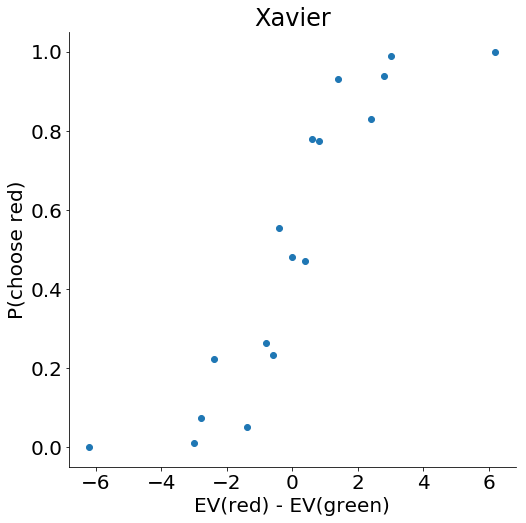

In [22]:
pChooseRed = data.groupby(['deltaEV'])['choseRed'].agg(['mean'])

_,ax = plt.subplots(1,1,figsize=[8,8])
ax.errorbar(pChooseRed.index,pChooseRed['mean'].values,fmt='o')
plt.xlabel('EV(red) - EV(green)')
plt.ylabel('P(choose red)')
plt.title('Xavier')

# Fit a simple model of animal behavior "by hand"

Our model should be a non-linear transformation that transforms the difference in expected value into a probability of choosing an option. 

One way is to fold our expected value into a simple linear model, then use the logistic function and perform logistic regression:

\begin{equation}
V = b_0 + b_1(EV_{red} - EV_{green})
\end{equation}

\begin{equation}
h = logistic(EV_{red} - EV_{green}) = \frac{1}{1 + e^{V}}
\end{equation}

In [7]:
#Takes a weighted relative valuation of each option, which in our case will be the difference in 
#the EV of the red and green targets.
choiceModel = lambda x,b: b[0]+b[1]*x

#Converts the weighted relative valuation into a probability of an action.
logistic = lambda x :1./(1.+np.exp(-x))

Now we want to fit our model. We need to specify a cost function, e.g. a log-loss function. A common one is the negative log-bernoulli loss function, which is used in regular logsitic regression:

\begin{equation}
-LL = -\sum_{i=1}^{n} y_ilog(h) + (1-y_i)log(1-h)
\end{equation}

where $y_i$ is the animal's choice on trial i, and n is the total number of trials.

In [8]:
#Now we want to fit our model. To do this, we'll set up a likelihood function, and then fold
#our three equations together to make a single objective function. We can plug our data
#into the objective function, then run it through an optimization algorithm. 

#This is the standard negative log-bernoulli loss function.
#I've added protection against taking the log of zero
cost = lambda y,h: -np.sum(y*np.log(np.max([h,np.ones(len(h))*realmin],axis=0))+
(1-y)*np.log(np.max([1-h,np.ones(len(h))*realmin],axis=0))); 

#Hook up all of the equations to eachother to make an objective function
objective = lambda x,y,b: cost(y,logistic(choiceModel(x,b)))

#Fit it!
initialGuesses = [1,1] #Normally we should do something like a grid search, but this is a linear model
optimizationOutput = optimize.minimize(lambda b: objective(data['deltaEV'],data['choseRed'],b),initialGuesses)
coefEstimates = optimizationOutput.x

In [9]:
#Did it actually work? Lets use StatsModels to fit a linear model.
#The coefficient estimates should be identical.
y,X = patsy.dmatrices('choseRed ~ deltaEV',data)
linearModel = GLM(
    endog=y,exog=X,family=sm.genmod.families.family.Binomial()
).fit()
coefTruth = linearModel.params

In [10]:
#The coefficient estimates from our model and the StatsModels model should be roughly equal.
print('Manual coef. values: '+str(coefEstimates))
print('Regression coef. values: ' + str(coefTruth))

Manual coef. values: [0.04067677 1.07373477]
Regression coef. values: [0.04067678 1.07373477]


Text(0.5,1,'Xavier')

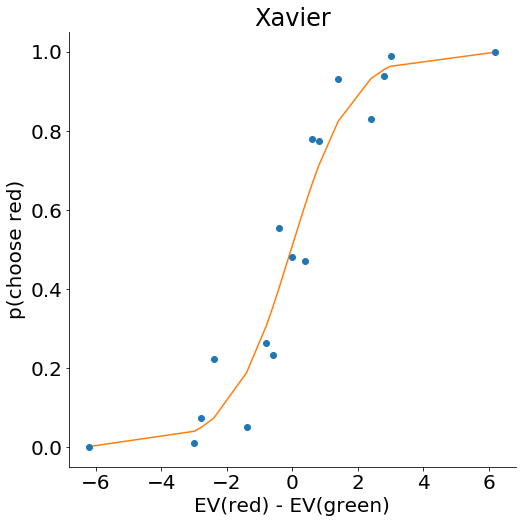

In [23]:
# Lets visualize model performance. How well does it capture choice behavior?

predictions = logistic(choiceModel(pChooseRed.index,coefEstimates))

_,ax = plt.subplots(1,1,figsize=[8,8])
ax.errorbar(pChooseRed.index,pChooseRed['mean'].values,fmt='o')
ax.plot(pChooseRed.index,predictions)
ax.set_xlabel('EV(red) - EV(green)')
ax.set_ylabel('p(choose red)')
ax.set_title('Xavier')

# A more complicated model: reinforcement learning

The previous model assumes that the animal uses true probabilities to estimate expected value. Actually, the probabilities are changing constantly, and must be estimated in real-time based on the animals' experience.

Further reading:

A book: https://drive.google.com/file/d/1opPSz5AZ_kVa1uWOdOiveNiBFiEOHjkG/view

A paper: http://www.princeton.edu/~ndaw/d10.pdf


Let $\hat{P_i}$ be our animals' subjective belief about the probability that the red target yields a reward on trial i. After the animal observes an outcome on trial i, $R_i$, the animal will update their belief using the following rule:

\begin{equation}
\hat{P_{i+1}} = \hat{P_{i}} + {\alpha}(R_i - \hat{P_i})
\end{equation}

where $\alpha$ is a learning rate parameter, which can be fitted.

Using this model, we can explicitly model the animal's belief about the reward probability on each trial, which is based on the animal's experience.

In [12]:
#A simple TD learner. This learns the probability that an animal
#is rewarded after selecting the red target or the green target
#
#Because p(reward|chose red) = 1 - p(reward|chose green), we will
#assume that the animal tracks a single probability. 
def temporalDifferenceLearner(choice,outcome,learningRate):
    
    #Our learner's dumb initial estimate of reward probaiblity
    pRed = .5
    pGreen = 1 - pRed
    
    p = np.zeros([len(choice)])
    for i in range(0,len(choice)):
        #Store information about the probability
        p[i] = pRed
        
        #our learner's belief about how likely a reward was this trial
        pReward = choice[i]*pRed + (1-choice[i])*pGreen
        
        #How surprised were we about the outcome (magnitude),
        #and was it a good or bad surprise (sign)?
        rewardPredictionError = outcome[i] - pReward
        
        #Update the learner's belief
        if(choice[i]):#if chose red
            pRed = pReward + learningRate*rewardPredictionError
            pGreen = 1 - pRed
        elif(not choice[i]):
            pGreen = pReward + learningRate*rewardPredictionError
            pRed = 1 - pGreen
        else:
            raise ValueError("Choice was %d on trial %d" % (choice[i],i))
            
    return p
                

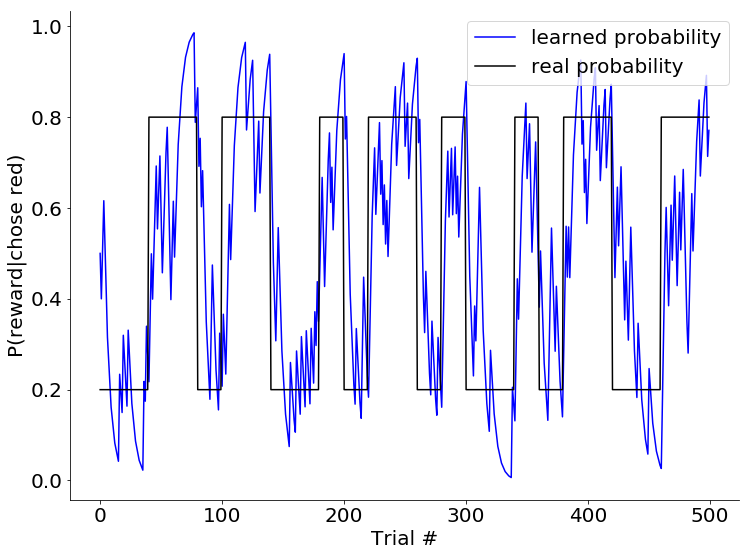

In [24]:
#How well does one of these learners do?
learningRate = .2
learnedPRed = temporalDifferenceLearner(data['choseRed'],data['rewarded'],learningRate)

ntrial = 500
_,ax = plt.subplots(1,1,figsize=[12,9])
ax.plot(data.index[0:ntrial],learnedPRed[0:ntrial],'-b',label='learned probability')
ax.plot(data.index[0:ntrial],data['redProb'][0:ntrial],'-k',label='real probability')
ax.set_ylabel('P(reward|chose red)')
ax.set_xlabel('Trial #')
ax.legend(loc=1)

In [14]:
#Lets write a function for learning, then estimating EV
def learnedDeltaEV(data,learningRate):
    learnedPRed = temporalDifferenceLearner(data['choseRed'],data['rewarded'],learningRate)
    estimatedDeltaEV = learnedPRed*data['redMag'] - (1-learnedPRed)*data['greenMag']
    return estimatedDeltaEV

estimatedPChooseRed = lambda x,b: logistic(choiceModel(learnedDeltaEV(x,b[0]),b[1:3]))
objectiveRL = lambda x,y,b: cost(y,estimatedPChooseRed(x,b))

In [27]:
#Fit it!
initialGuessesRL = [.15,.03,1.5] #Normally we should do something like a grid search, but this is a linear model
optimizationOutputRL = optimize.minimize(lambda b: objectiveRL(data,data['choseRed'],b),initialGuessesRL)
paramsRL = optimizationOutputRL.x
print('Learning rate=%.2f, b0=%.2f, b1=%.2f' % (paramsRL[0],paramsRL[1],paramsRL[2]))

Learning rate=0.16, b0=0.04, b1=1.56


Text(0,0.5,'P(choose red)')

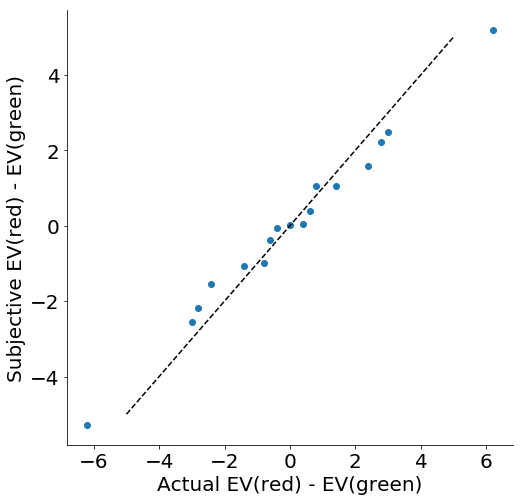

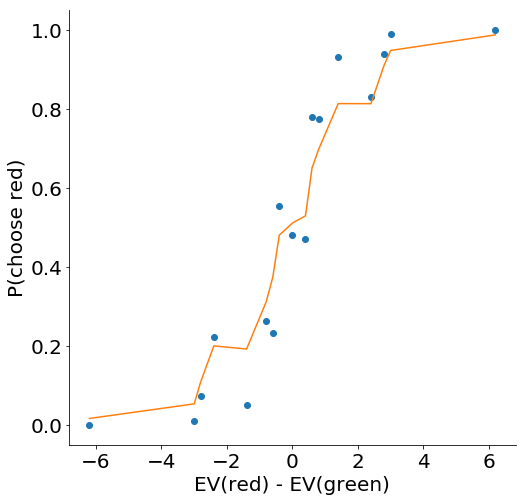

In [25]:
data['estimatedEV'] = learnedDeltaEV(data,paramsRL[0])
data['estimatedPChooseRed'] = estimatedPChooseRed(data,paramsRL)
realVsSubjectiveEV = data.groupby(['deltaEV'])['estimatedEV'].agg(['mean'])

_,ax = plt.subplots(1,1,figsize=[8,8])
ax.scatter(realVsSubjectiveEV.index,realVsSubjectiveEV.values)
ax.plot([-5,5],[-5,5],'--k')
ax.set_xlabel('Actual EV(red) - EV(green)')
ax.set_ylabel('Subjective EV(red) - EV(green)')

pChooseRedRL = data.groupby(['deltaEV'])['estimatedPChooseRed'].agg(['mean'])

_,ax = plt.subplots(1,1,figsize=[8,8])
ax.plot(pChooseRed.index,pChooseRed.values,'o')
ax.plot(pChooseRedRL.index,pChooseRedRL.values)
ax.set_xlabel('EV(red) - EV(green)')
ax.set_ylabel('P(choose red)')